In [1]:
## Imports

import glob
import os

import random

# Import local modules containing all functions
from helpers import *

In [2]:
## Load all sample files

filedir = "/Users/aaronkarp/Documents/Thesis/testSounds"   # "/Volumes/External Storage/Thesis/Corpus/eng-balm-emmanuel/flac"
segment_length = 0.1  # length of segments in seconds

sounds, samplerates = load_sounds(filedir)
spectrograms, mfccs, rmss, centroids, max_num_segs = analyze_sounds(sounds, samplerates, segment_length)

num_files = len(sounds)

directory = '/Users/aaronkarp/Documents/Thesis/Code/savedData/'
to_save = [['samplerates', samplerates], ['spectrograms', spectrograms], ['mfccs', mfccs], ['rmss', rmss], ['centroids', centroids]]
save_data(to_save, directory)

Loading...
7%     13%     20%     27%     33%     40%     47%     53%     60%     67%     73%     80%     87%     93%     Finished Loading
Analyzing...
7%     13%     20%     27%     33%     40%     47%     53%     60%     67%     73%     80%     87%     93%     Finished Analyzing

Average number of segments:  13.866666666666667
saved samplerates
saved spectrograms
saved mfccs
saved rmss
saved centroids


In [3]:
## Organize features into lists of segments
# feature1 = [segment1 segment2 segment3]
# segment1 = nxm np.matrix 

spectrograms_by_seg, spectrograms_by_seg_flat = segment_matrix(spectrograms, max_num_segs, num_files)
mfccs_by_seg, mfccs_by_seg_flat = segment_matrix(mfccs, max_num_segs, num_files)
centroids_by_seg, centroids_by_seg_flat = segment_matrix(centroids, max_num_segs, num_files)

In [4]:
## Build/save LSHs for all features

spec_engines = []
mfcc_engines = []
centroid_engines = []
num_bits = 20 # How many bits to use for hashing

for seg in spectrograms_by_seg_flat:
    spec_engines.append(build_lsh(seg, num_bits))
for seg in mfccs_by_seg_flat:
    mfcc_engines.append(build_lsh(seg, num_bits))
for seg in centroids_by_seg_flat:
    centroid_engines.append(build_lsh(seg, num_bits))
    
reboot_directory()
save_engines(spec_engines, 'spectrogram')
save_engines(mfcc_engines, 'mfcc')
save_engines(centroid_engines, 'centroid')

Original query: eng-0a5edfe0.flac


Best guess: 9


Second best guess: 6


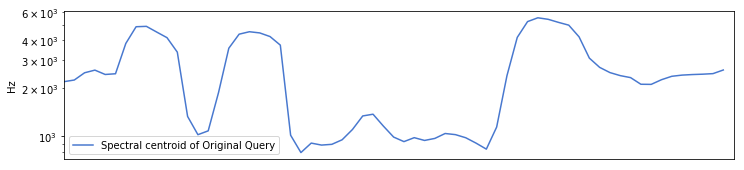

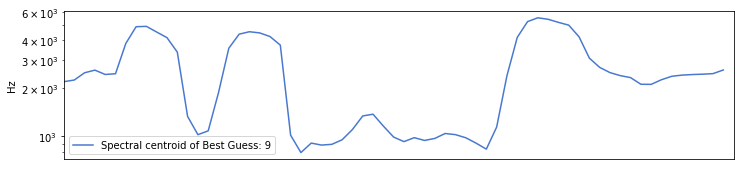

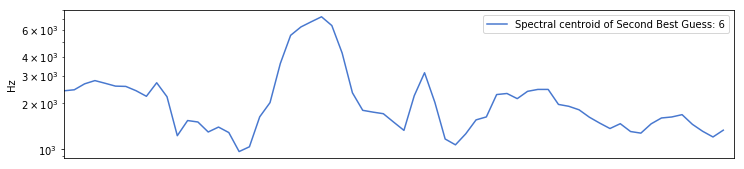

Guesses: 9 : 7.771561172376096e-16
6 : 0.011010224712756034
11 : 0.018297744273554906
3 : 0.020744838384438746
14 : 0.024453054059672574
Original query: eng-0a5edfe0.flac


Best guess: 9


Second best guess: 3


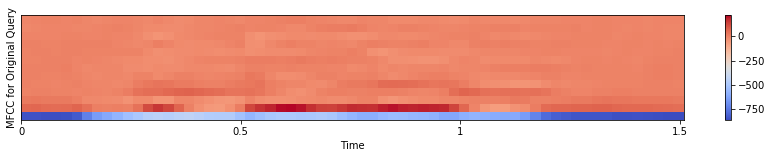

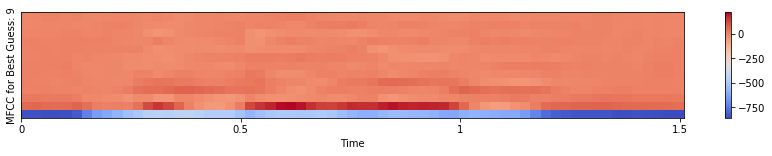

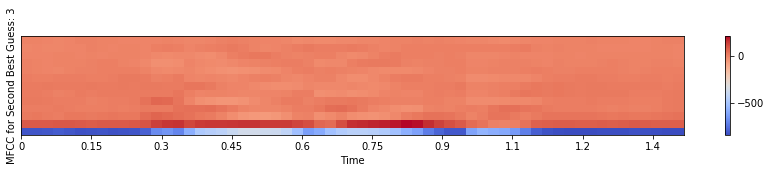

Guesses: 9 : 6.661338147750939e-16
3 : 0.003011615458083039
2 : 0.012369126421384546
5 : 0.019886215253381967
4 : 0.02668466038821049
Original query: eng-0a5edfe0.flac


Best guess: 9


Second best guess: 10


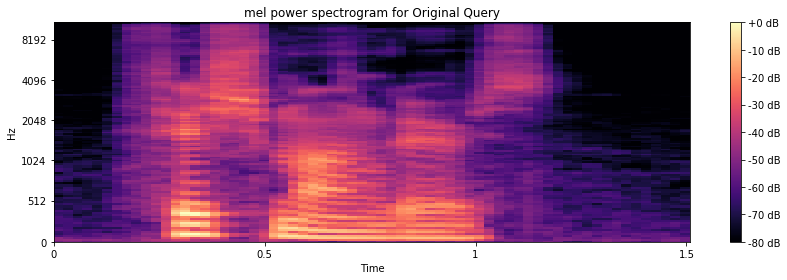

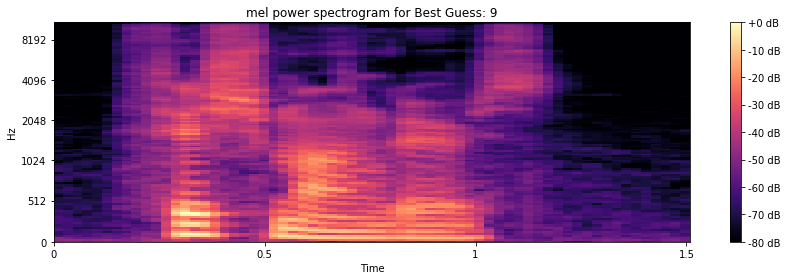

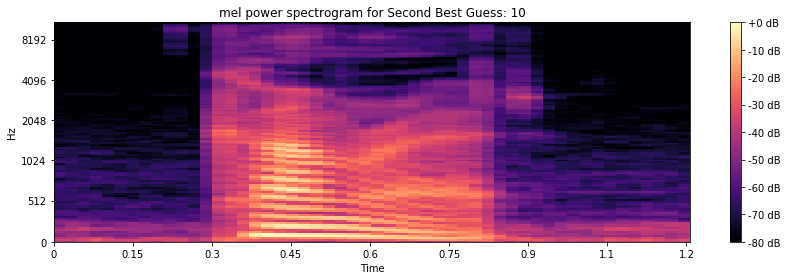

Guesses: 9 : 1.1102230246251565e-16
10 : 0.007414198013907525
3 : 0.010998393009275076
6 : 0.022620981316407662
5 : 0.025676212516742014


Original Query: 



Best guesses: 
Sound #9 : 1.5543122344752192e-15


Sound #3 : 0.03475484685179686


Sound #2 : 0.08183977320995572


Sound #5 : 0.1202162503917732


In [5]:
## Load engines and Query

# Load engines
spec_engines = load_engines('spectrogram')
mfcc_engines = load_engines('mfcc')
centroid_engines = load_engines('centroid')

# Choose random sound in directory
os.chdir("/Users/aaronkarp/Documents/Thesis/testSounds")  # ("/Volumes/External Storage/Thesis/Corpus/eng-balm-judith/flac")
files = []
files.extend(glob.glob("*.wav"))
files.extend(glob.glob("*.flac"))
to_check = random.choice(files)


# Do the ANN distances

cum_distances = [0]*num_files  # The combined distance measures

guesses, distances = query_sound(to_check, centroid_engines, num_files, sounds, samplerates, segment_length = segment_length,
                                 display=True, match_type='centroid')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]
      
guesses, distances = query_sound(to_check, mfcc_engines, num_files, sounds, samplerates, segment_length = segment_length,
                                 display=True, match_type='mfcc')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]

guesses, distances = query_sound(to_check, spec_engines, num_files, sounds, samplerates, segment_length = segment_length,
                                 display=True, match_type='spectrogram')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]

cum_guesses = sorted(range(len(cum_distances)), key=lambda k : cum_distances[k])

print("\n\nOriginal Query: ")
y,sr = librosa.load(to_check)
ipd.display(ipd.Audio(y, rate=sr)) # load matched file
print("\nBest guesses: ")
for i in range(0, 4):
    print("Sound #" + str(cum_guesses[i]) + " : " + str(cum_distances[cum_guesses[i]]))
    ipd.display(ipd.Audio(sounds[cum_guesses[i]], rate = samplerates[cum_guesses[i]])) # load matched file